## 练习2
一个小球被一个长度位 r 的绳子吊着，再小球自然悬挂静止时，给他水平 x 正方向初速度 v，小球运动会受到空气的阻力，
和速度成正比，c，求他的轨迹，注意绳子是软的，
计算到球到左边最高点时停下，或者绳子不在拉直，小球下落到绳子再次拉直为止。


因为有二阶导数，所以y和y'都是需要求解的对象,y''就比较麻烦了，
加速度是由空气阻力，重力同时提供的。

我们这里为了简单，我门吧求走过的弧长作为要求的函数Ds,顺时针为正方向，那么加速度可以写作：
dVdt = -np.sin(Ds[0] / r) * g - Ds[1] * dragCoef
第一项位重力提供的，绳子方向上，垂直速度分量没有效果，只有平行分量有，第二项位空气阻力

当绳子承受的力<0的时候球进入自由落体运动。这个运动写个新的ODE：`fall(t,Y)`，
不再用Ds弧度作为求解对象，而是使用x，y笛卡尔坐标系。

$$
\begin{cases}
y'=y'\\
y''=-np.sin(Ds[0] / r) * g - Ds[1] * dragCoef\\
\end{cases}
$$

In [1]:
from scipy.integrate import solve_ivp
import numpy as np
import matplotlib.pyplot as plt


In [2]:
# the swing process
def swing(t, Ds):
    dDdt = Ds[1]
    dVdt = -np.sin(Ds[0] / r) * g - Ds[1] * dragCoef
    return np.array([dDdt, dVdt])

# the fall process
def fall(t, Y):
    # there are 4 unknowns x,y and x', y'
    # return y', y'',x',x''
    return np.array([Y[1], -g - Y[1] * dragCoef, Y[3], -Y[3] * dragCoef])

# when the rope does not pull, stop swinging and start falling
def fallEvent(t, Ds):
    fall = 1
    D = Ds[0]
    V = Ds[1]
    # the rope has 0 force then fall
    if V**2 / r + np.cos(D / r) * g <= 0:  
        fall = 0
    return fall

fallEvent.terminal = True
fallEvent.direction = -1

# when the ball stopped at the left top position, stop the swing process
def topEvent(t, Ds):
    return Ds[1]

topEvent.terminal = True
topEvent.direction = 1

#  when the ball is out of the circular path, limitied by the rope length, 
# stop the free process
def outEvent(t, Ys):
    y = Ys[0]
    x = Ys[2]
    value = 1
    #  when the ball is out of the circular path, limitied by the rope length, give it a margin
    if x ** 2 + y ** 2 > r+0.01:  
        value = 0
    return value

outEvent.terminal = True
outEvent.direction = -1


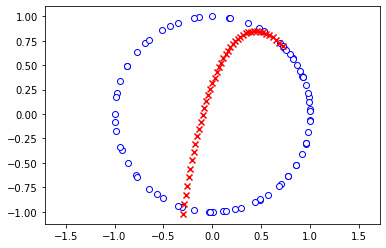

In [13]:
r = 1  # radius of swing, rope length
g = 9.8
dragCoef = 1  # drag coeffient / speed

t0 = 0
tf = 30
# initial speed when the ball is at the bottom, clockwise is positive
speed0 = 20

# start at the bottom with speed0
D0 = [0, speed0]  

# solve the swing process
sol0 = solve_ivp(swing, [t0, tf], D0, events=[fallEvent, topEvent], max_step=0.02)
solSwing = sol0.y[0]

solFall = []
# if event 0 (fallEvent) stopped the solution process, then it starts to fall 
if sol0.t_events[0].any():  
    # the postion and speed when the event happend
    De = sol0.y_events[0][0]
    V = De[1]  # the speed tangential to the circular trajectory
    D = De[0]  # the position of the ball at the circular trajectory
    # calculate the x, y speed of ball
    speedx = np.cos(D / r) * V
    speedy = np.sin(D / r) * V
    # calculate the x, y position of ball
    y0 = -np.cos(D / r)
    x0 = np.sin(D / r)
    # solve the fall process
    fall0 = [y0, speedy, x0, speedx]  # initial condition of free fall
    sol1 = solve_ivp(fall, [t0, tf], fall0, events=outEvent, max_step=0.02)
    solFall = sol1.y

# draw
plt.xlim((-1.1 * r, 1.1 * r))
plt.ylim((-1.1 * r, 1.1 * r))
plt.axis('equal')

for D in solSwing:
    y = -np.cos(D / r)
    x = np.sin(D / r)
    plt.scatter(x, y, c='w', edgecolors='b', marker='o')

if len(solFall) != 0:
    for i in range(solFall.shape[1]):
        y = solFall[0][i]
        x = solFall[2][i]
        plt.scatter(x, y, c='r', marker='x')

plt.show()
